# Monte Carlo Methods

<div class="alert alert-info">

- Implement Episode Generation (2 Points)
- Implement MC Policy Evaluation (6 Points)
- Implement MC On-Policy Control (6 Points)
- Analysis of MC on Fishlake (1 Point)


Some# Blackjack - A Model-free Environment, Monte Carlo Methods

Let us now try Monte Carlo methods on a model-free environment (where it is very hard / impossible to use Dynamic Programming). We will use the game of Black Jack, as presented in the lecture. In general, MC methods are model free, but you might have used some convenience functions

<div class="alert alert-info">

The following description is adapted from the environment description at https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py:

    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over. They're playing against dealer
    that follows a fixed strategy.
    
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    
    This game is played with an infinite deck (drawing with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.
    
    If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.
    
    The reward for winning is +1, drawing is 0, and losing is -1.
    
    The observation is a 3-tuple of:
    
    the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.

### Preliminaries

What follows are the imports, the instantiation of the BlackJack gym-environment, and the introduction of some helper functions. You will have to run these cells first, before starting to implement and run your algorithms.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gym
import fishlake_updated as fishlake
import blackjack_convenience as blackjack

from collections import defaultdict

np.set_printoptions(precision=4, suppress=True, threshold=200)

### Let's play some BlackJack...

In [3]:
# the BlackJack environment does **not** give access to the dynamics or the size of the state space
# so there is no (easy) way we can use dynamic programming here, we are forced to use model-free methods
# the BlackJack environment has no 'render()' function either --- printing the state encoding is enough
blackjack_env = gym.make('Blackjack-v1')

# we can query the size of the action space:
print('Size of the action space:', blackjack_env.action_space.n)

# we can (indirectly) query the size of the observation space:
print('Structure/sizes of the observation space:', blackjack_env.observation_space)

# we can seed the PRNG of the environment for:
# - reproducability
# - easier debugging
# the PRNG is used by the environment to determine the order of the cards
blackjack_env.seed(1234)

# to reset the environment into its inital state, we can call 'reset()'
state = blackjack_env.reset()

# let's look at the components of the state encoding of the initial state
print(state)

Size of the action space: 2
Structure/sizes of the observation space: Tuple(Discrete(32), Discrete(11), Discrete(2))
(20, 3, False)


### The state encoding desugars into this ...

In [4]:
(player_score, dealer_score, usable_ace) = state

 ... but this is not really important for us!
Because the state is already a tuple, we will just use this tuple as a key into several dictionaries. They will store various value function approximations, policies, as well as support data.

## Defining Default BlackJack Policies

What follows are functions that generate basic policies.

In [5]:
# we include here the example policy that was also used in class:
def create_example_policy():
    """
    Create a policy that sticks if the player score is >= 20 and hits otherwise.
    """
    policy = dict()
    for score in range(4, 22):  # 4 - 21
        for dealer_score in range(1, 11):  # 1 - 10
            for useable_ace in [True, False]:
                observation = (score, dealer_score, useable_ace)
                if score >= 20:
                    # stick
                    policy[observation] = np.array([1.0, 0.0])
                else:
                    # hit
                    policy[observation] = np.array([0.0, 1.0])
    return policy

# and the random policy that chooses an action with equal probability
def create_random_policy():
    """
    Create the random policy.
    """
    policy = dict()
    
    for score in range(4, 22):
        for dealer_score in range(1, 11):
            for useable_ace in [True, False]:
                observation = (score, dealer_score, useable_ace)
                policy[observation] = np.array([0.5, 0.5])   
    return policy

---
## (1) Episode Generation (2 Points)
Here, you will define a helper function that will generate an episode, given an environment and a policy.

In [6]:
def generate_episode(rng, env, policy):
    # implement a helper function to generate an episode, given an environment and a policy
    # an episode is a list of (state, action, reward) tuples:
    # episode = [
    #    (state_1, action_1, reward_2),
    #    (state_2, action_2, reward_3),
    #    ...
    #    (state_T-1, action_T-1, reward_T)
    # ]
    state = env.reset()
    actions = np.arange(env.action_space.n)
    episode = []
    done = False
    
    while not done:
        action = rng.choice(actions, p=policy[state])
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        
    return episode

In [7]:
rng = np.random.default_rng(1245)
blackjack_env.seed(4321)
random_policy = create_random_policy()
episode = generate_episode(rng, blackjack_env, random_policy)
for s, a, r in episode:
    print(s, a, r)

(12, 10, True) 1 0.0
(13, 10, True) 1 0.0
(18, 10, True) 1 0.0
(18, 10, False) 1 -1.0


## (2) Monte Carlo Evaluation (6 Points)
Ler's get started: implement the every-visit MC policy evaluation algorithm.

In [8]:
def getReturn(episode, gamma):
    G = 0    
    for i, (state, action, reward) in enumerate(episode):
        G += (gamma**i) * reward
    
    return G

In [9]:
def mc_policy_evaluation(rng, env, policy, n_episodes, gamma=1.0, n_print_every=10 ** 4):
    """
    Monte Carlo prediction algorithm, which calculates the value function
    for a given policy
    
    Args:
        env: the openai gym environment
        policy: the policy to be evaluated
        n_episodes: number of episodes to sample
        gamma: the discount factor
    
    Returns:
        the value function associated with 'policy'
    """
    # a note on the value function estimate 'V', 'G_sum' and 'G_count':
    # those functions must be stored as a 'dict' or 'defaultdict', where
    #
    # 'key' is a tuple encoding the state (player_sum, dealer_sum, useable_ace)
    #
    # and
    #
    # 'value' is the value of this state
    #
    # print(V) should yield something similar to this (except for the actual numerical values):
    #
    #     defaultdict(float,
    #             {(21, 10, True): 0.8863134657836644,
    #              (7, 10, False): -0.563816604708798,
    #              (11, 10, False): -0.10879368658399098,
    #              (20, 10, False): 0.43548387096774194,
    #              (13, 7, True): -0.3431372549019608,
    #              (12, 7, False): -0.5573080967402734,
    #              (21, 7, False): 0.9257294429708223,
    #              (13, 6, False): -0.5404255319148936,
    #              (19, 6, False): -0.6908077994428969,
    #              ...})
    #
    # please make sure you use this format, as only then the very convenient plotting function will work
    #
    # for more info checkout the documentation on 'defaultdict':
    # https://docs.python.org/3/library/collections.html?highlight=defaultdict#collections.defaultdict
    #
    # if this is too much voodoo for you, you can use 'dict', but you have to do extra steps there
    # in case a key does not exist in the dictionary yet!
    G_sum = defaultdict(lambda: 0.)
    G_count = defaultdict(lambda: 0.)
    V = defaultdict(lambda: 0.)
        
    for i_episode in range(1, n_episodes + 1):
        if i_episode % n_print_every == 0:
            print("\rEpisode {}/{}.".format(i_episode, n_episodes))

        # TODO: generate an episode
        episode = generate_episode(rng, env, policy)

        # TODO: compute return G, update G_sum, G_count
        # TODO: compute the value function estimate 'V' from 'G_sum' and 'G_count'
        for idx, (state, action, reward) in enumerate(episode):
            G = getReturn(episode[idx:], gamma)
            G_count[state] += 1
            G_sum[state] += G
            V[state] = G_sum[state] / G_count[state]
    
    return V

### Run MC Policy Evaluation for Black Jack
Okay, let's now run the implemented algorithm on the Black Jack environment. You already know from the lecture slides what the output should roughly look like.

In [10]:
# let's create the example policy
example_policy = create_example_policy()

# TODO: for debugging, it might be a good idea to set this to a smaller value -> only temporarily though!
# set it back to (5 * 10 ** 4) before you re-run and submit your notebook!
n_episodes = 5 * 10 ** 4

seed_sequence = np.random.SeedSequence(1234)
rng = np.random.default_rng(seed_sequence)

# and now let's see how good the example policy really is
policy_value = mc_policy_evaluation(rng, blackjack_env, example_policy, n_episodes=n_episodes)

Episode 10000/50000.
Episode 20000/50000.
Episode 30000/50000.
Episode 40000/50000.
Episode 50000/50000.


<Figure size 432x288 with 0 Axes>

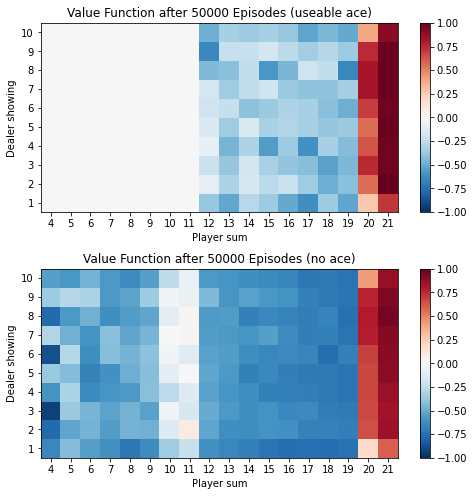

In [11]:
blackjack.plot_value_function(policy_value, title=f"Value Function after {n_episodes} Episodes")

## (3) Monte Carlo Control (6 Points)
Implement the On-policy every-visit MC control for ε-soft policies algorithm.

In [12]:
def mc_control_epsilon_greedy(rng, env, initial_policy, n_episodes=100, gamma=1.0, epsilon=0.1, n_print_every=10 ** 4):
    """
    On-policy every-visit MC control for ε-soft policies algorithm
    Computes an optimal epsilon-greedy policy.
    
    Args:
        env: the openai gym environment
        initial_policy: the inital policy as a dict with the state as the key,
                        and the values being numpy arrays that store the
                        action selection probabilities
        n_episodes: number of episodes to sample
        gamma: the discount factor
        epsilon: chance to sample a random action
    
    Returns:
        a tuple (policy, Q)
        opt_policy is a dict in the same format as the initial_policy
        Q is a dict with the state as the key,
        and an np.array as value, which contains the state-action values
"""
    
    # see the note on datastructures in 'mc_policy_evaluation(...)'!
    G_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    G_count = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = defaultdict(lambda: list())
    
    # make a copy of the inital policy (it's bad style to change input parameters)
    policy = {k: v.copy() for k, v in initial_policy.items()}
    
    for i_episode in range(1, n_episodes + 1):
        if i_episode % n_print_every == 0:
            print("\rEpisode {}/{}.".format(i_episode, n_episodes))

        # TODO: generate an episode
        episode = generate_episode(rng, env, policy)
        # TODO: compute return G, update G_sum, G_count, and Q
        for idx, (state, action, reward) in enumerate(episode):
            G = getReturn(episode[idx:], gamma)
            returns[(state, action)].append(G)
            Q[state][action] = np.mean(returns[(state, action)])
            
        # TODO: derive an epsilon-soft policy from Q
        for idx, (state, action, reward) in enumerate(episode):
            best_action = np.argmax(Q[state])
            
            policy[state][:] = (epsilon/env.action_space.n)
            policy[state][best_action] += 1 - epsilon
        
    return policy, Q

### Run MC Control for Black Jack
Finally, let's compute a better policy for the Black Jack game. One hint: the results may differ slightly from the lecture slides. They will also be different from the optimal policies in the book, as the ones in the book were computed with 'Exploring Starts'. Do not worry too much about it, but you can always try with a few more samples...

In [13]:
# here, we start from the example policy
# policy = create_example_policy()
n_episodes = 10 ** 5
n_print_every = 10 ** 4
initial_policy = create_random_policy()

# and now run our MC control algorithm
opt_policy, opt_Q = mc_control_epsilon_greedy(
    rng,
    blackjack_env,
    initial_policy,
    n_episodes=n_episodes,
    epsilon=0.1,
    n_print_every=n_print_every
)

# determine how good our policy is, in terms of v(s)
opt_V = mc_policy_evaluation(
    rng,
    blackjack_env,
    opt_policy,
    n_episodes=n_episodes,
    n_print_every=n_print_every
)

Episode 10000/100000.
Episode 20000/100000.
Episode 30000/100000.
Episode 40000/100000.
Episode 50000/100000.
Episode 60000/100000.
Episode 70000/100000.
Episode 80000/100000.
Episode 90000/100000.
Episode 100000/100000.
Episode 10000/100000.
Episode 20000/100000.
Episode 30000/100000.
Episode 40000/100000.
Episode 50000/100000.
Episode 60000/100000.
Episode 70000/100000.
Episode 80000/100000.
Episode 90000/100000.
Episode 100000/100000.


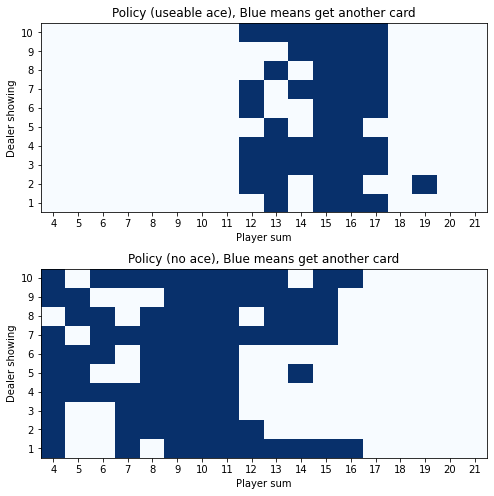

<Figure size 432x288 with 0 Axes>

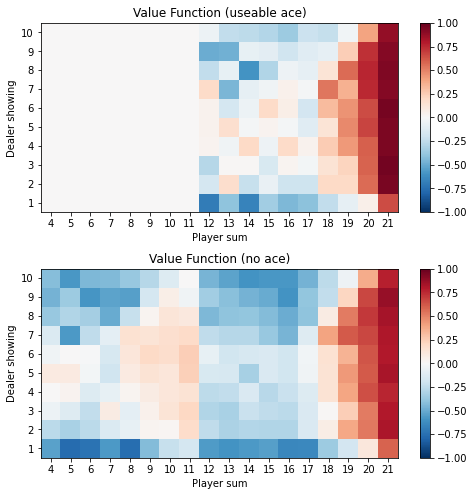

In [14]:
# plot the policy
blackjack.plot_policy(opt_policy)

# and its associated value function
blackjack.plot_value_function(opt_V)

---
# Fishlake Revisited with Monte Carlo methods
We will now go back to the Fishlake and run the MC algorithms on this problem. You will need to answer a textual question, after you tried MC on the Fishlake environment.

In order to run MC, we will need a few convenience functions for converting a value function and policy (a dict in the MC algorithms) to arrays, so we can re-use the existing plotting functions for the Fishlake environment.

In [15]:
def d2a_policy(env, policy):
    policy_array = np.zeros((env.observation_space.n, env.action_space.n))
    for state, ap in policy.items():
        policy_array[state, :] = ap
    return policy_array

def d2a_V(env, V):
    V_array = np.zeros(env.observation_space.n)
    for state, value in V.items():
        V_array[state] = value
    return V_array

def fishlake_random_policy(env):
    policy = defaultdict()
    for state in range(env.observation_space.n):
        policy[state] = np.ones(env.action_space.n) / env.action_space.n
    return policy    

## Run MC Evaluation on Fishlake

In [16]:
# we start with the smaller lake
small_lake_env = gym.make('FishlakeStreamy-v0')
small_lake_env.seed(1234)

# let's create a random policy
random_policy = fishlake_random_policy(small_lake_env)

# and now let's see how good our policy is
rng = np.random.default_rng(4321)
V_dict = mc_policy_evaluation(rng, small_lake_env, random_policy, 200)

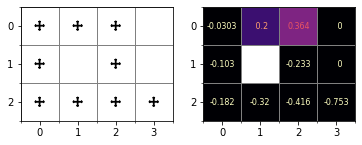

In [17]:
# let's plot this
random_policy_array = d2a_policy(small_lake_env, random_policy)
V_array = d2a_V(small_lake_env, V_dict)

fig, axes = plt.subplots(ncols=2)
fishlake.plot_policy(axes[0], small_lake_env, random_policy_array)
fishlake.plot_value_function(axes[1], small_lake_env, V_array)
plt.show()

## Run MC Control on Fishlake

In [18]:
# we start with the smaller lake
small_lake_env = gym.make('FishlakeStreamy-v0')
small_lake_env.seed(1234)

# let's create a random policy
initial_policy = fishlake_random_policy(small_lake_env)
rng = np.random.default_rng(4321)
opt_policy, opt_Q = mc_control_epsilon_greedy(
    rng,
    small_lake_env,
    initial_policy,
    n_episodes=10 ** 4,
    epsilon=0.1
)

# and now let's see how good our policy is
opt_V = mc_policy_evaluation(rng, small_lake_env, opt_policy, n_episodes=10 ** 4)

Episode 10000/10000.
Episode 10000/10000.


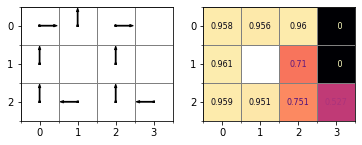

In [19]:
# let's plot this
opt_policy_array = d2a_policy(small_lake_env, opt_policy)
opt_V_array = d2a_V(small_lake_env, opt_V)

fig, axes = plt.subplots(ncols=2)
fishlake.plot_policy(axes[0], small_lake_env, opt_policy_array)
fishlake.plot_value_function(axes[1], small_lake_env, opt_V_array)
plt.show()

### (4) Differences DP/MC (1 Point)
Compare the results from MC Evaluation and Control with the results you got via dynamic programming in the last exercise. What could be the reasons for the differences you are seeing?

Answer: TODO